# **Model Zoo -- Convolutional Autoencoder with Nearest-neighbor Interpolation**

## **Libraries**

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [3]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.05
num_epochs = 10
batch_size = 128

## **MNIST dataset**

In [4]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

In [5]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [6]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Model**

In [7]:
class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)                                       
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)                 
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)
        
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)
        
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_3(x)
        x = F.leaky_relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_4(x)
        logits = F.leaky_relu(x)
        probas = torch.sigmoid(logits)
        return logits, probas

In [8]:
torch.manual_seed(random_seed)
model = ConvolutionalAutoencoder()
model = model.to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## **Training**

In [10]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)

        logits, decoded = model(features)
        cost = F.binary_cross_entropy_with_logits(logits, features)
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 0.7008
Epoch: 001/010 | Batch 050/469 | Cost: 0.1979
Epoch: 001/010 | Batch 100/469 | Cost: 0.1301
Epoch: 001/010 | Batch 150/469 | Cost: 0.1137
Epoch: 001/010 | Batch 200/469 | Cost: 0.1093
Epoch: 001/010 | Batch 250/469 | Cost: 0.1028
Epoch: 001/010 | Batch 300/469 | Cost: 0.1022
Epoch: 001/010 | Batch 350/469 | Cost: 0.1018
Epoch: 001/010 | Batch 400/469 | Cost: 0.1048
Epoch: 001/010 | Batch 450/469 | Cost: 0.0972
Time elapsed: 1.02 min
Epoch: 002/010 | Batch 000/469 | Cost: 0.0958
Epoch: 002/010 | Batch 050/469 | Cost: 0.1016
Epoch: 002/010 | Batch 100/469 | Cost: 0.0958
Epoch: 002/010 | Batch 150/469 | Cost: 0.0965
Epoch: 002/010 | Batch 200/469 | Cost: 0.0938
Epoch: 002/010 | Batch 250/469 | Cost: 0.0939
Epoch: 002/010 | Batch 300/469 | Cost: 0.0951
Epoch: 002/010 | Batch 350/469 | Cost: 0.0906
Epoch: 002/010 | Batch 400/469 | Cost: 0.0966
Epoch: 002/010 | Batch 450/469 | Cost: 0.1073
Time elapsed: 2.05 min
Epoch: 003/010 | Batch 000/469 | C

## **Evaluation**

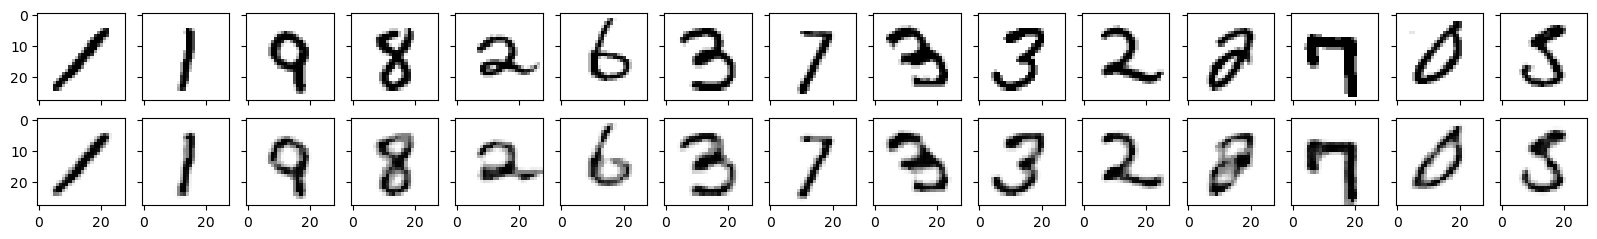

In [11]:
n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')